<a href="https://colab.research.google.com/github/ghafoor545/100DaysOfBuildables/blob/main/task8_hyperparameter_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("camnugent/california-housing-prices")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'california-housing-prices' dataset.
Path to dataset files: /kaggle/input/california-housing-prices


📌 Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
df = pd.read_csv("/content/sample_data/california_housing_train.csv")

# Create categorical features
df["income_cat"] = pd.cut(df["median_income"],
                          bins=[0, 2, 4, 6, np.inf],
                          labels=["Low", "Medium", "High", "Very High"])

df["age_cat"] = pd.cut(df["housing_median_age"],
                       bins=[0, 10, 20, 30, 40, 60],
                       labels=["0-10", "11-20", "21-30", "31-40", "40+"])

X = df[["housing_median_age", "total_rooms", "total_bedrooms", "population", "median_income", "income_cat", "age_cat"]]
y = df["median_house_value"]

# Preprocessing
numeric_features = ["housing_median_age", "total_rooms", "total_bedrooms", "population", "median_income"]
categorical_features = ["income_cat", "age_cat"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
baseline_model = Pipeline(steps=[("preprocessor", preprocessor),
                                 ("model", RandomForestRegressor(random_state=42))])

baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_test)

baseline_mae = mean_absolute_error(y_test, y_pred_base)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_base))
baseline_r2 = r2_score(y_test, y_pred_base)

print("Baseline Performance:")
print("MAE:", baseline_mae)
print("RMSE:", baseline_rmse)
print("R²:", baseline_r2)



Baseline Performance:
MAE: 48969.83863235294
RMSE: 67720.87443033223
R²: 0.6671625399830692


In [4]:
param_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [None, 10, 20],
    "model__max_features": ["auto", "sqrt"],
    "model__min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(
    estimator=Pipeline(steps=[("preprocessor", preprocessor),
                              ("model", RandomForestRegressor(random_state=42))]),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring="r2"
)

grid_search.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
81 fits failed out of a total of 162.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
41 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **l

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['housing_median_age',
                                                                          'total_rooms',
                                                                          'total_bedrooms',
                                                                          'population',
                                                                          'median_income']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['income_cat',
                                                                          'age_cat'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__max_features': ['auto', 'sqrt'],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [50, 100, 200]},
             scoring='r2')

In [5]:
print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

tuned_mae = mean_absolute_error(y_test, y_pred_tuned)
tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
tuned_r2 = r2_score(y_test, y_pred_tuned)

print("Tuned Performance:")
print("MAE:", tuned_mae)
print("RMSE:", tuned_rmse)
print("R²:", tuned_r2)


Best Parameters: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 200}
Tuned Performance:
MAE: 50680.76916138898
RMSE: 69204.83052764884
R²: 0.6524158984680524


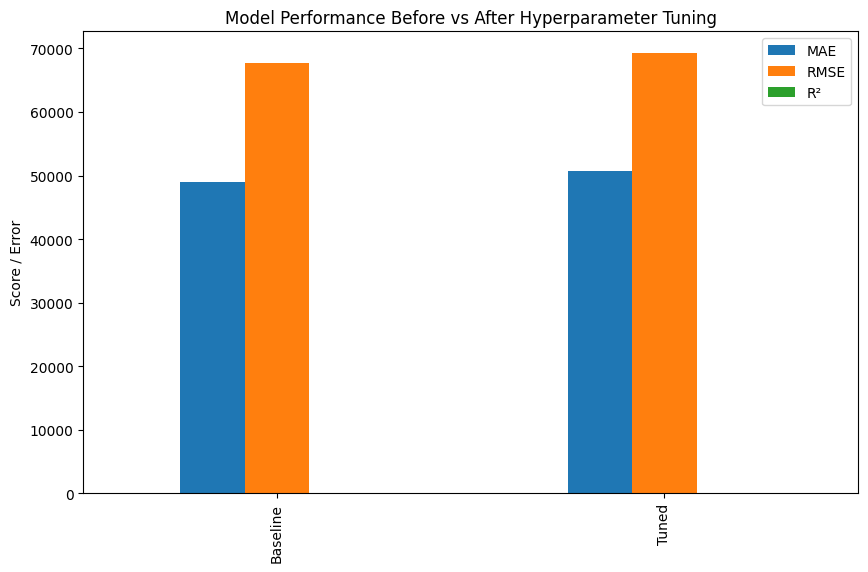

In [6]:
results = pd.DataFrame({
    "MAE": [baseline_mae, tuned_mae],
    "RMSE": [baseline_rmse, tuned_rmse],
    "R²": [baseline_r2, tuned_r2]
}, index=["Baseline", "Tuned"])

results.plot(kind="bar", figsize=(10,6))
plt.title("Model Performance Before vs After Hyperparameter Tuning")
plt.ylabel("Score / Error")
plt.show()
